In [1]:
import os 


os.environ['KAGGLE_USERNAME'] = "ankitkumar2117"

os.environ['KAGGLE_KEY'] = "b553e85b776c6041763213a2f543c737"

! kaggle datasets download -d omkargurav/face-mask-dataset

 96% 157M/163M [00:01<00:00, 99.2MB/s]
100% 163M/163M [00:01<00:00, 96.3MB/s]


In [2]:

# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2021-12-02 13:42:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.004s  

2021-12-02 13:42:39 (2.64 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
unzip_data('face-mask-dataset.zip')

In [4]:
walk_through_dir('data')

There are 2 directories and 0 images in 'data'.
There are 0 directories and 3725 images in 'data/with_mask'.
There are 0 directories and 3828 images in 'data/without_mask'.


In [8]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (229, 160, 3)


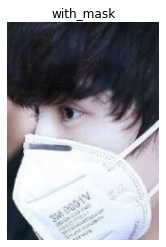

In [9]:
# View a random image 
img = view_random_image(target_dir="/content/data/",
                        target_class="with_mask")

In [5]:
train_dir = "data/"

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42, subset='training' )

valid_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42, subset="validation")

Found 5665 images belonging to 2 classes.
Found 1888 images belonging to 2 classes.


In [7]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_2.compile(loss="binary_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
history_2 = model_2.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))


Epoch 1/5
  5/178 [..............................] - ETA: 19s - loss: 0.8229 - accuracy: 0.4812

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


178/178 [==============================] - 42s 160ms/step - loss: 0.3932 - accuracy: 0.8297 - val_loss: 0.2574 - val_accuracy: 0.9036
Epoch 2/5
178/178 [==============================] - 29s 161ms/step - loss: 0.2614 - accuracy: 0.8939 - val_loss: 0.2707 - val_accuracy: 0.9004
Epoch 3/5
178/178 [==============================] - 28s 158ms/step - loss: 0.2377 - accuracy: 0.9082 - val_loss: 0.2193 - val_accuracy: 0.9131
Epoch 4/5
178/178 [==============================] - 30s 166ms/step - loss: 0.2124 - accuracy: 0.9183 - val_loss: 0.2471 - val_accuracy: 0.9031
Epoch 5/5
178/178 [==============================] - 30s 165ms/step - loss: 0.1911 - accuracy: 0.9234 - val_loss: 0.2144 - val_accuracy: 0.9184


In [11]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img



def pred_and_plot(model, filename):
  
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred=pred.round()
  if pred==0:
    pred_class="With_Mask"
  else:
    pred_class="Without_mask"  

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

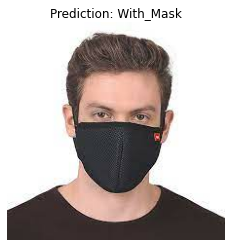

In [12]:
# Test our model 
pred_and_plot(model_2, "/content/test img.jpg")